In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint, solve_ivp
from scipy.signal import find_peaks

Question 1: Complex calcium oscillations

In [64]:
# Declare parameters
#---------------------------------------
#Total concentrations (micro Moles)
Ca_tot =  90 
Pr_tot = 120

# Geometric Parameters

rho_ER = 0.01
rho_m = 0.01
beta_ER = 0.0025
beta_m = 0.0025

#Kinetics parameters

k_pump = 20 #s^-1
k_ch = 3900 #s^-1
k_leak = 0.05 #s^-1
k_in = 300 #(micro Moles s^-1)
k_out = 125 #s^-1
k_m = 0.00625 #s^-1
k_plus = 0.1 #(micro Moles)
k_minus = 0.01 #s^-1
K1 = 5 #(micro Moles)
K2 = 0.8 #(micro Moles)
K3 = 5 #(micro Moles)

#Initial concentrations (micro Moles)

Ca_cyt_0 = 0.3 
Ca_ER_0 = 0.2 
Ca_m_0 = 1 

In [65]:
def Ca_system(y, t, k_pump=k_pump, k_ch=k_ch, k_leak=k_leak, k_in=k_in, k_out=k_out, k_m=k_m, k_plus=k_plus, k_minus=k_minus, K1=K1, K2=K2, K3=K3, Ca_tot=Ca_tot, Pr_tot=Pr_tot, beta_ER=beta_ER, beta_m=beta_m, rho_ER=rho_ER, rho_m=rho_m):
    Ca_cyt, Ca_ER, Ca_m = y
    J_pump = k_pump*Ca_cyt
    J_ch = k_ch*((Ca_cyt**2)/(K1**2 + Ca_cyt**2))*(Ca_ER - Ca_cyt)
    J_leak = k_leak*(Ca_ER - Ca_cyt)
    J_in = k_in*(Ca_cyt**8)/(K2**8 + Ca_cyt**8)
    J_out = Ca_m*(((k_out*Ca_cyt**2) / (K3**2 + Ca_cyt**2))+k_m)
    CaPr = Ca_tot - Ca_cyt -(rho_ER/beta_ER)*Ca_ER - (rho_m/beta_m)*Ca_m
    Pr = Pr_tot - CaPr
    
    return [J_ch + J_leak - J_pump + J_out - J_in + k_minus*CaPr - k_plus*Ca_cyt*Pr, 
           (beta_ER/rho_ER)*(J_pump - J_ch - J_leak), (beta_m/rho_m)*(J_in - J_out)]

def solve_system(t_span, y0, t_eval, system=Ca_system, method='LSODA', rtol=1e-10, atol=1e-10, **kwargs):
    final_system = lambda y, t: system(t, y, **kwargs)
    sol = solve_ivp(final_system, t_span, y0, method=method, t_eval=t_eval, rtol=rtol, atol=atol)
    return sol.t, sol.y

e) Build the model in python and plot the calcium concentrations in all three compartments over time ($t = 0 − 300$) for $k_{ch} = 3900s^{−1}$ using
$\{ Ca_{cyt}(0), Ca_{ER}(0), Ca_{m}(0) \} = \{ 0.3, 0.2, 1 \}$ as initial conditions.

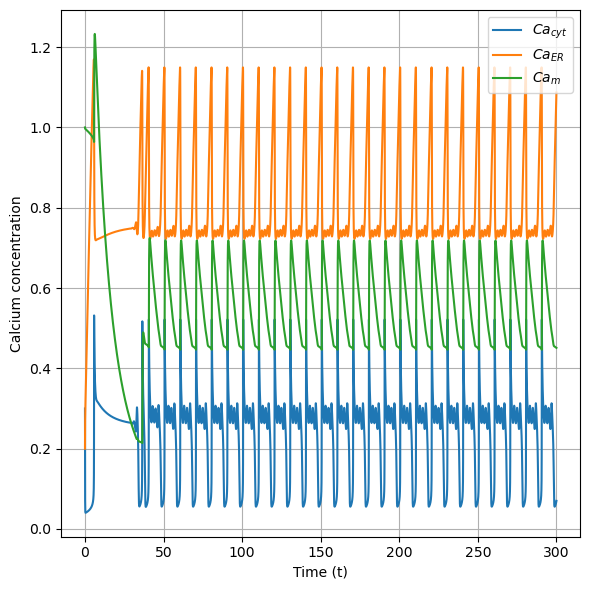

In [66]:
t_span = (0, 300)
t_eval = np.linspace(*t_span, 100_000) # very high resolution for phase plots
y0 = [Ca_cyt_0, Ca_ER_0, Ca_m_0]
t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval)
Ca_cyt, Ca_ER, Ca_m = y[0], y[1], y[2]

def viz_system(t, y):
    plt.figure(figsize=(6, 6), layout='tight')
    plt.plot(t, y[0], label='$Ca_{cyt}$')
    plt.plot(t, y[1], label='$Ca_{ER}$')
    plt.plot(t, y[2], label='$Ca_m$')
    plt.legend(loc='upper right')
    plt.xlabel('Time (t)')
    plt.ylabel('Calcium concentration')
    plt.grid()
    plt.show()

viz_system(t, y)

h) Create the three 2D-phase plots and analyse them. Identify any possible closed orbits and describe them.

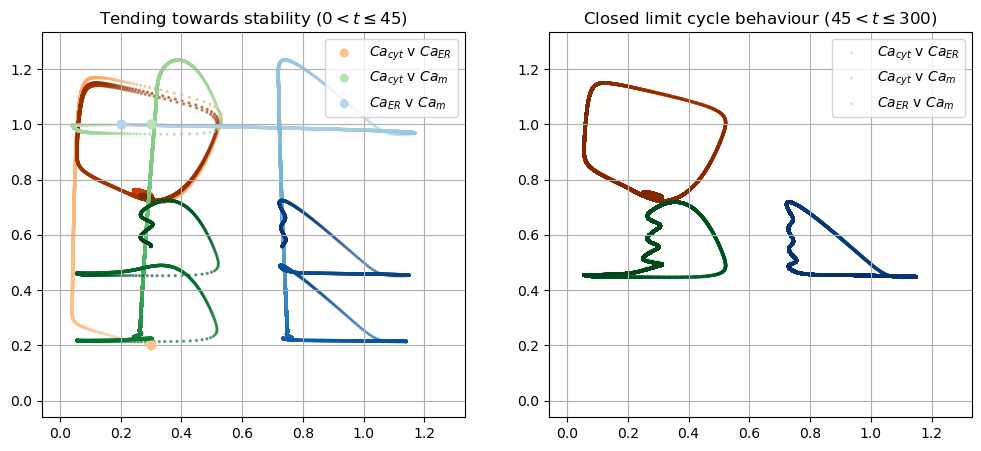

In [67]:
def viz_2d_phaseplots(t, y, ranges, titles):
    '''Provided time series data of concentrations y, visualize 2D phase plots of all pairs of concentrations in subplots for each time range separately'''
    Ca_cyt, Ca_ER, Ca_m = y[0], y[1], y[2]
    fig = plt.figure(figsize=(12,5))
    cmap_names = ['Oranges', 'Greens', 'Blues']
    # Reshape cmaps to be offset and start at darker colors for visibility
    new_cmaps = [ListedColormap(plt.get_cmap(name)(np.linspace(0.3, 1, 256))) for name in cmap_names]
    pairs = [(Ca_cyt, Ca_ER), (Ca_cyt, Ca_m), (Ca_ER, Ca_m)]
    pair_names = ['$Ca_{cyt}$ v $Ca_{ER}$', '$Ca_{cyt}$ v $Ca_m$', '$Ca_{ER}$ v $Ca_m$']
    x_min = y_min = min([y_i.min() for y_i in y]) - 0.1
    x_max = y_max = max([y_i.max() for y_i in y]) + 0.1

    for i, (r_lower, r_upper) in enumerate(ranges):
        ax = fig.add_subplot(1, len(ranges), i+1)
        mask = (t >= r_lower) & (t < r_upper)
        t_range = t[mask]
        norm = Normalize(t_range.min(), t_range.max())
        for j, (pair, name) in enumerate(zip(pairs, pair_names)):
            cmap = new_cmaps[j]
            sc = ax.scatter(pair[0][mask], pair[1][mask], label=name, c=t[mask], cmap=cmap, s=2, norm=norm, alpha=0.5)
            # Plot starting points
            if i == 0:
                initial_color = cmap(norm(t[0]))
                ax.scatter(pair[0][0], pair[1][0], color=initial_color, s=40, zorder=10)
        legend = ax.legend()
        ax.set_title(titles[i])

        # Increase the size of the legend markers
        for handle in legend.legend_handles:
            handle._sizes = [30]
            handle.set_alpha(1)
        ax.grid(True)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    plt.legend(loc='upper right')

    plt.show()

ranges = [(0, 45), (45, 300)]
titles = [f'Tending towards stability (${ranges[0][0]} < t \\leq {ranges[0][1]}$)', f'Closed limit cycle behaviour (${ranges[1][0]} < t \\leq {ranges[1][1]}$)']
viz_2d_phaseplots(t, y, ranges, titles)

i) Create the 3D-phase plot and check if your conclusions in (g) still stand.

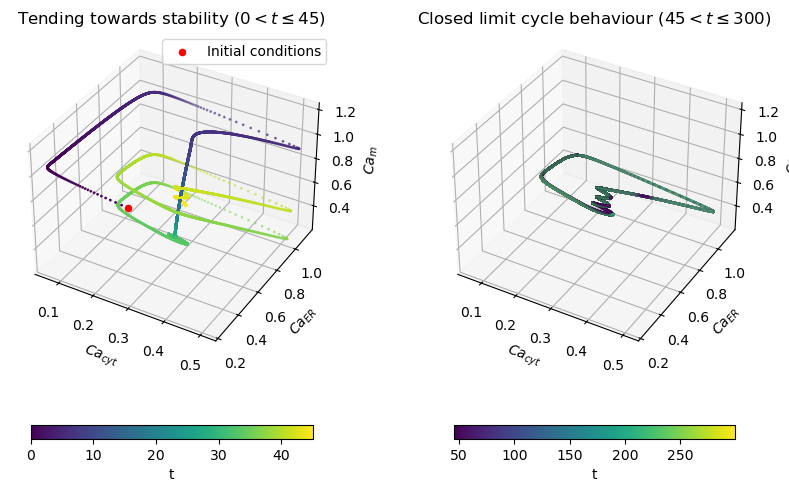

In [68]:
def viz_3d_phaseplots(t, y, ranges, titles):
    '''Provided time series data of concentrations y, visualize 3D phase plots of the triplet of concentrations in subplots for each time range separately'''
    Ca_cyt, Ca_ER, Ca_m = y[0], y[1], y[2]
    fig = plt.figure(figsize=(10,6))
    cmap = 'viridis'

    for i, (r_lower, r_upper) in enumerate(ranges):
        ax = fig.add_subplot(1, len(ranges), i+1, projection='3d')
        mask = (t >= r_lower) & (t < r_upper)
        t_range = t[mask]
        norm = Normalize(t_range.min(), t_range.max())
        sc = ax.scatter(Ca_cyt[mask], Ca_ER[mask], Ca_m[mask], c=t[mask], cmap=cmap, s=1, norm=norm)
        if i == 0:
            ax.scatter(Ca_cyt_0, Ca_ER_0, Ca_m_0, c='r', s=20, label='Initial conditions')
            ax.legend()
        ax.set_xlabel('$Ca_{cyt}$')
        ax.set_ylabel('$Ca_{ER}$')
        ax.set_zlabel('$Ca_m$')
        ax.view_init(elev=35, azim=-60)
        ax.set_xlim(Ca_cyt.min(), Ca_cyt.max())
        ax.set_ylim(Ca_ER.min(), Ca_ER.max())
        ax.set_zlim(Ca_m.min(), Ca_m.max())
        ax.set_title(titles[i])
        fig.colorbar(sc, ax=ax, label='t', orientation='horizontal', shrink=0.8)

    plt.show()

viz_3d_phaseplots(t, y, ranges, titles)

j) Now repeat the steps you took in (e) - (i) for $k_{ch} = 4000 s^{−1}$.

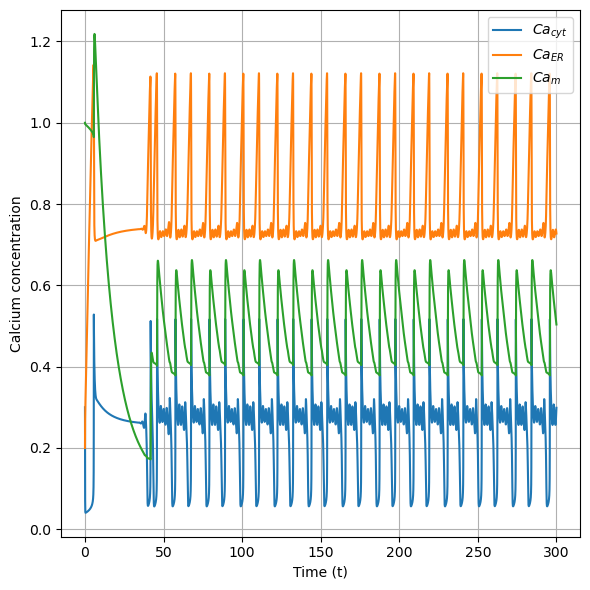

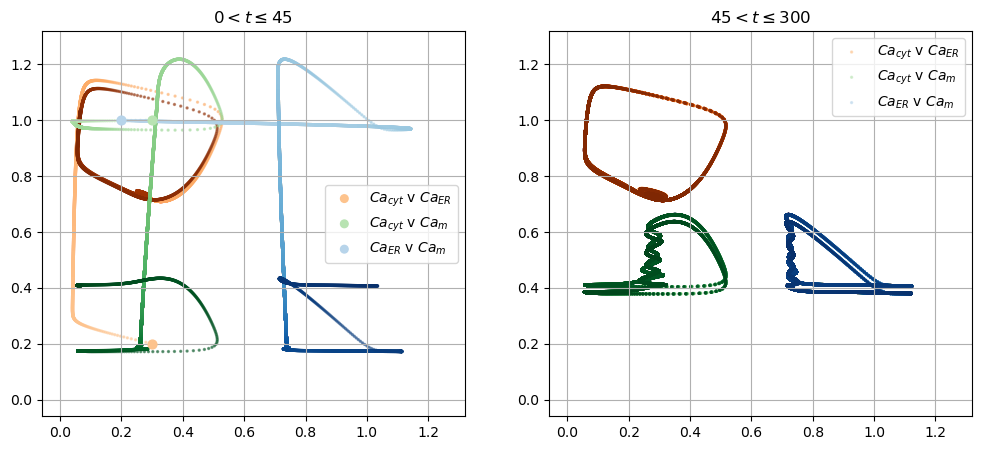

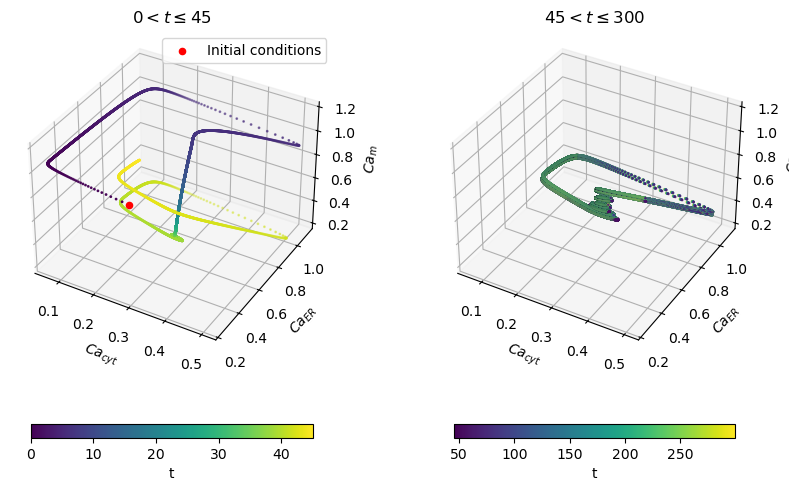

In [69]:
k_ch2 = 4000 # s^-1
t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=k_ch2)
viz_system(t, y)
ranges = [(0, 45), (45, 300)]
titles = [f'${range[0]} < t \\leq {range[1]}$' for range in ranges]
viz_2d_phaseplots(t, y, ranges, titles)
viz_3d_phaseplots(t, y, ranges, titles)

k) Now repeat the steps you took in (e) - (i) for $k_{ch} = 2830 s^{−1}$.

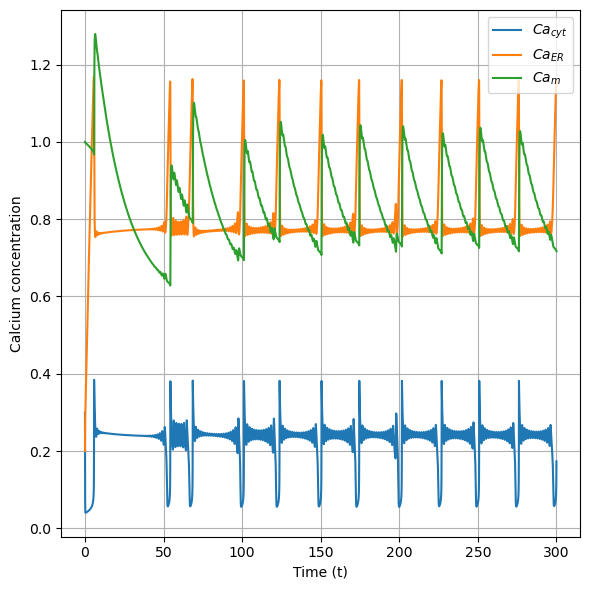

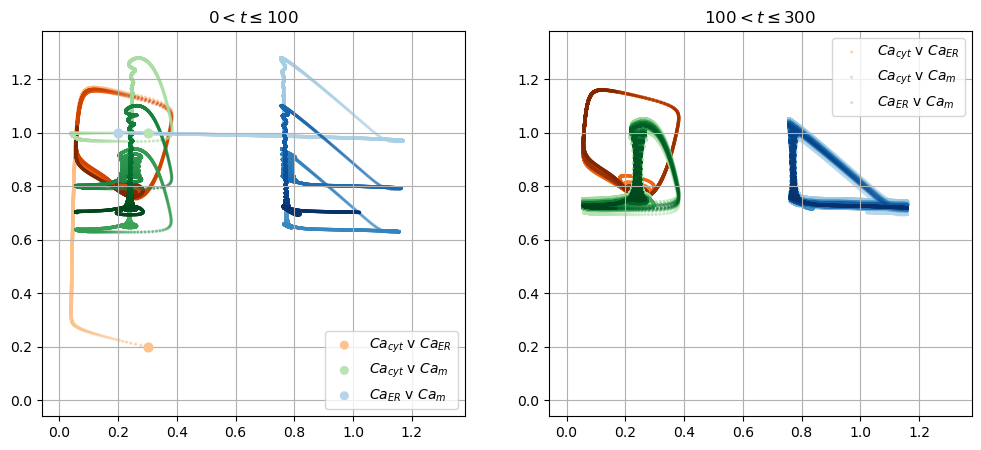

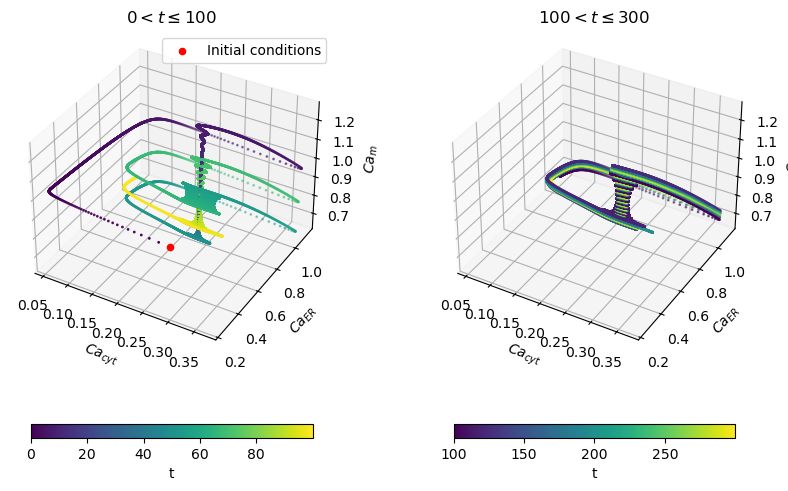

In [70]:
k_in3 = 2830 # s^-1
t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_in=k_in3)
viz_system(t, y)
ranges = [(0, 100), (100, 300)]
titles = [f'${range[0]} < t \\leq {range[1]}$' for range in ranges]
viz_2d_phaseplots(t, y, ranges, titles)
viz_3d_phaseplots(t, y, ranges, titles)

l) Create the Lorenz map based on the peaks in $Ca_m$ for the three values of $k_ch$ for $t = 100 - 1000$. Elaborate on your results. (Hint: The ﬁnd peaksfunction might come in handy)

Question 2: Schnakenberg model

In [72]:
#Laplace 1D

def laplace_1D(X, dx):
    Xleft = X[:-2]
    Xright = X[2:]
    return (Xleft + Xright - 2*X[1:-1])/dx**2

In [73]:
#Laplace 2D

def laplace_2D(X, dx):
    Xtop = X[:-2, 1:-1]
    Xbottom = X[2:, 1:-1]
    Xleft = X[1:-1, :-2]
    Xright = X[1:-1, 2:]
    return (Xtop + Xbottom + Xleft + Xright - 4*X[1:-1, 1:-1])/(dx**2)